# Лабораторная работа №4

ФИО:  **Йолсал Дениз Хайреттинович**   
Группа: **БИВТ-20-3**  
Вариант: **jbarat/plant_species**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

# 1. Загрузка датасета

In [ ]:
!pip install datasets

In [22]:
from datasets import load_dataset
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
dataset = load_dataset('jbarat/plant_species')

# 2. Описание датасета

In [39]:
print("тип - ",type(dataset))
print("столбцы - ", dataset.column_names)
print("тип - ",type(dataset['train']))
ds = dataset['train']

label_names = ['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum', 'albuca_spiralis', 'allium_cepa', 'allium_sativum']

тип -  <class 'datasets.dataset_dict.DatasetDict'>
столбцы -  {'train': ['image', 'label']}
тип -  <class 'datasets.arrow_dataset.Dataset'>


Данный датасет состоит из изображений растений и меток - порядковых номеров видов растений.
Всего в датасете 8 видов растений, пронумерованных с 0:

0. aechmea_fasciata - Эхмея полосатая
1. agave_americana - Агава американская
2. agave_attenuata - Агава оттянутая
3. agave_tequilana - Агава голубая
4. aglaonema_commutatum - Аглаонема переменчивая
5. albuca_spiralis - Альбука спиральная
6. allium_cepa - Лук репчатый
7. allium_sativum - Чеснок
 


Примеры изображений:

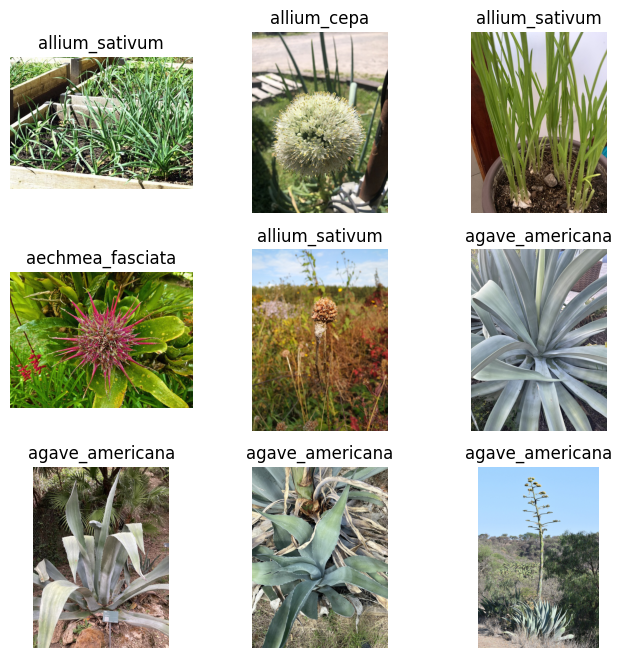

In [40]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]['image'], ds[sample_idx]['label']
    figure.add_subplot(rows, cols, i)
    plt.title(label_names[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# 3. Оформление датасета как Dataset из Pytorch

In [26]:
class DynamicCropAndResize:
    def __call__(self, image):
        min_size = min(image.size)  
        cropped_image = transforms.CenterCrop(min_size)(image)  
        resized_image = transforms.Resize([128, 128])(cropped_image)  
        return resized_image

to_transform = transforms.Compose([
    DynamicCropAndResize(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class LabelTransform:
    def __call__(self, label):
        new_label = torch.tensor(label, dtype=torch.float32)
        return new_label

label_to_transform = LabelTransform()

In [27]:
class CustomDataset(Dataset):
    def __init__(self, data, transform = None, label_transform = None):
        self.data = data
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

custom_dataset = CustomDataset(ds, transform = to_transform, label_transform=label_to_transform)

train_size = int(0.9 * len(custom_dataset)) 
test_size = len(custom_dataset) - train_size 

train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# 4. Оформление датасета в Dataloader

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size = 40, shuffle=True, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 40, shuffle=True, num_workers = 0)

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

dataloaders = {'train': train_dataloader, 'test': test_dataloader}

# 5. Реализация и тренировка своей модели

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [31]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())
            
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [32]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 5),
    nn.ELU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 16, 11),
    nn.ELU(),
    nn.MaxPool2d(4),

    nn.Conv2d(16, 16, 3),
    nn.ELU(),

    nn.Flatten(),

    nn.Linear(1936, 8), 
    nn.ELU(),
)
model = model.to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.0022, momentum=0.9, weight_decay=0.000001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=3, gamma=0.1)

In [34]:
model = train_model(model, dataloaders ,criterion, optimizer_sgd, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 2.0722 Acc: 0.1611
test Loss: 2.0578 Acc: 0.2000

Epoch 2/10
----------
train Loss: 1.9906 Acc: 0.2236
test Loss: 1.9491 Acc: 0.2125

Epoch 3/10
----------
train Loss: 1.8401 Acc: 0.3083
test Loss: 1.8631 Acc: 0.3250

Epoch 4/10
----------
train Loss: 1.7264 Acc: 0.3903
test Loss: 1.8546 Acc: 0.3375

Epoch 5/10
----------
train Loss: 1.7030 Acc: 0.3917
test Loss: 1.8134 Acc: 0.3375

Epoch 6/10
----------
train Loss: 1.6792 Acc: 0.3889
test Loss: 1.7991 Acc: 0.3750

Epoch 7/10
----------
train Loss: 1.6601 Acc: 0.4028
test Loss: 1.7853 Acc: 0.3625

Epoch 8/10
----------
train Loss: 1.6571 Acc: 0.4111
test Loss: 1.7975 Acc: 0.3375

Epoch 9/10
----------
train Loss: 1.6583 Acc: 0.4069
test Loss: 1.7904 Acc: 0.3625

Epoch 10/10
----------
train Loss: 1.6576 Acc: 0.3958
test Loss: 1.7879 Acc: 0.3625

Training complete in 4m 41s
Best val Acc: 0.375000


# 6. Обучение с помощью Transfer Learning

In [35]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 8)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0022, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [37]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
train Loss: 1.8466 Acc: 0.3458
test Loss: 1.4618 Acc: 0.5375

Epoch 2/5
----------
train Loss: 0.8743 Acc: 0.7222
test Loss: 0.9430 Acc: 0.7000

Epoch 3/5
----------
train Loss: 0.4374 Acc: 0.8931
test Loss: 0.9171 Acc: 0.6500

Epoch 4/5
----------
train Loss: 0.2502 Acc: 0.9417
test Loss: 0.8677 Acc: 0.7000

Epoch 5/5
----------
train Loss: 0.1776 Acc: 0.9667
test Loss: 0.8232 Acc: 0.7875

Training complete in 5m 48s
Best val Acc: 0.787500


# 7. Метрики качества, выводы

## Метрики качества
 -  Собственная сеть
   - По итогу 10 эпохи получаем следующие значения:
     - `train Loss: 1.6576 Acc: 0.3958`
     - `test Loss: 1.7879 Acc: 0.3625`
   - Лучшая точность на тестах:
     - `Best val Acc: 0.375000`
   - Время обучения: 
     - `Training complete in 4m 41s (cpu)`
 - ResNet18 с дообучением всех слоёв
   - По итогу 5 эпохи получаем следующие значения:
     - `train Loss: 0.1776 Acc: 0.9667`
     - `test Loss: 0.8232 Acc: 0.7875`
   - Лучшая точность на тестовом наборе:
     - `Best val Acc: 0.787500`
   - Время обучения:
     - Training complete in 5m 48s (cpu)

 В случае с ResNet18 закончил на 5 эпохах, т.к. заняло приблизительно то же время, и уже на 5 эпохах очевидны результаты сравнения.

В целом сделал небольшое количество эпох, т.к. в ходе тестирования и допиливания кода много раз прогонял обучение, в итоге Colab ограничил доступ к GPU, а на CPU обучение длится заметно дольше.

## Выводы

1. В ходе перебора различных вариантов моделей создавал модели, которые показывали точность около 90-95% на тренировочном наборе, однако точность ниже 20% на тестовом наборе, что явно свидетельствовало о переобучении. Причиной этого были слишком большие модели (вплоть до 100.000 нейронов в некоторых слоях, соответственно миллионы параметров)

2. Мне удалось натренировать собственную модель, чтобы она выдавала результаты заметно лучше чем случайное угадывание (37.5% вместо 12.5% для рандома, что ровно в 3 раза больше). 

3. Однако, после 5-6 эпохи польза от обучения модели практически прекращается, loss на тестовом наборе практически не улучшается. Хотя loss на тренировочном наборе слабо, но продолжает улучшаться, что говорит о дальнейшем переобучении модели.

4. Модель ResNet18 показала в разы лучшие результаты (на тестовом наборе loss 0.8232 против 1.7879 у моей модели и точность ~79% против 37.5% у моей модели).

5. Сам процесс обучения у ResNet18 происходит примерно в 2 - 2.5 раза медленнее, однако это не играет особой роли, т.к. даже при меньшем количестве эпох она обучается заметно лучше моей модели.